## Setup and Imports

In [1]:
! pip install -U -q transformers
! pip install -U -q accelerate
! pip install -U -q datasets

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from transformers import (
    AutoProcessor,
    PaliGemmaForConditionalGeneration
)
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw, ImageFont

## Configuration

In [3]:
dataset_id = "ariG23498/license-detection-paligemma"
model_id = "google/paligemma-3b-pt-224"

device = "cuda:0"
dtype = torch.bfloat16

batch_size = 8
learning_rate = 5e-5

## Dataset for Fine Tuning

In [4]:
train_dataset = load_dataset(dataset_id, split="train")
val_dataset = load_dataset(dataset_id, split="validation")
test_dataset = load_dataset(dataset_id, split="test")

In [5]:
print(f"{len(train_dataset)=}")
print(f"{len(val_dataset)=}")
print(f"{len(test_dataset)=}")

len(train_dataset)=4323
len(val_dataset)=1482
len(test_dataset)=371


In [6]:
processor = AutoProcessor.from_pretrained(model_id)

In [7]:
def collate_train_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Detect license plate." for _ in examples]
    suffix = [example["label_for_paligemma"] for example in examples]

    # Help from: https://github.com/huggingface/transformers/issues/30987
    inputs = processor(
        images=images,
        text=prompt,
        suffix=suffix,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs

def collate_test_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Detect license plate." for _ in examples]

    inputs = processor(
        images=images,
        text=prompt,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs

In [8]:
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=False,
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_test_fn,
    batch_size=batch_size,
    shuffle=False,
)

## Model creation

In [9]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Freezing everything but the attention layers

In [10]:
for name, param in model.named_parameters():
    if "attn" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [11]:
for name, param in model.named_parameters():
    print(f"{name:<70}: requires_grad={param.requires_grad}, dtype={param.dtype}")

vision_tower.vision_model.embeddings.patch_embedding.weight           : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.embeddings.patch_embedding.bias             : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.embeddings.position_embedding.weight        : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias      : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias      : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.bias      : requires_grad=True, d

## Dummy forward pass

In [12]:
val_batch = next(iter(val_dataloader))
test_batch = next(iter(test_dataloader))

In [13]:
print(f"{val_batch.keys()=}")
print(f"{test_batch.keys()=}")

val_batch.keys()=dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'labels'])
test_batch.keys()=dict_keys(['input_ids', 'attention_mask', 'pixel_values'])


In [14]:
outputs = model(**val_batch)
print(f"{outputs.loss=}")

outputs.loss=tensor(5.6800, device='cuda:0', grad_fn=<NllLossBackward0>)


## Results Before Fine Tuning

In [15]:
with torch.inference_mode():
    generation = model.generate(**test_batch, max_new_tokens=100, do_sample=False)
    decoded = processor.batch_decode(generation, skip_special_tokens=True)

In [16]:
for element in decoded:
    location = element.split("\n")[1]
    if location == "":
        print("No bbox found")
    else:
        print(location)

No bbox found
No bbox found
No bbox found
No bbox found
No bbox found
No bbox found
No bbox found
No bbox found


## Fine tune the model

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(1):
    for idx, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        if idx % 500 == 0:
            print(f"Epoch: {epoch} Iter: {idx} Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0 Iter: 0 Loss: 5.6340
Epoch: 0 Iter: 500 Loss: 2.2826


## Results After Fine Tuning

In [18]:
DETECT_RE = re.compile(
    r'(.*?)' +
    r'((?:<loc\d{4}>){4})\s*' +
    r'([^;<>]+) ?(?:; )?',
)

In [19]:
def extract_objects(detection_string, image_width, image_height, unique_labels=False):
    objects = []
    seen_labels = set()

    while detection_string:
        match = DETECT_RE.match(detection_string)
        if not match:
            break

        prefix, locations, label = match.groups()
        location_values = [int(loc) for loc in re.findall(r'\d{4}', locations)]
        y1, x1, y2, x2 = [value / 1024 for value in location_values]
        y1, x1, y2, x2 = map(round, (y1 * image_height, x1 * image_width, y2 * image_height, x2 * image_width))

        label = label.strip()  # Remove trailing spaces from label

        if unique_labels and label in seen_labels:
            label = (label or '') + "'"
        seen_labels.add(label)

        objects.append(dict(
            xyxy=(x1, y1, x2, y2),
            name=label
        ))

        detection_string = detection_string[len(match.group()):]

    return objects

In [31]:
def draw_bbox(image, objects):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for obj in objects:
        bbox = obj["xyxy"]
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 10, "plate", color='red', fontsize=12, weight='bold')
    plt.show()

In [21]:
with torch.inference_mode():
    generation = model.generate(**test_batch, max_new_tokens=100, do_sample=False)
    decoded = processor.batch_decode(generation, skip_special_tokens=True)

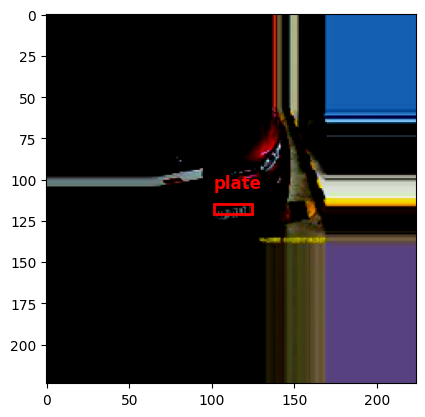

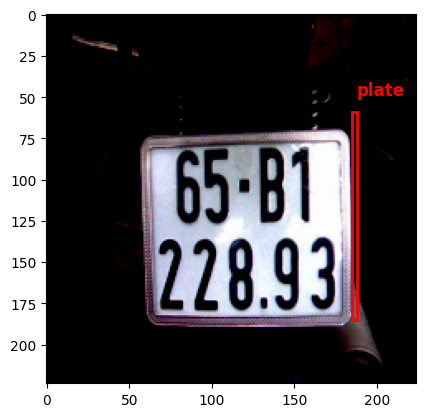

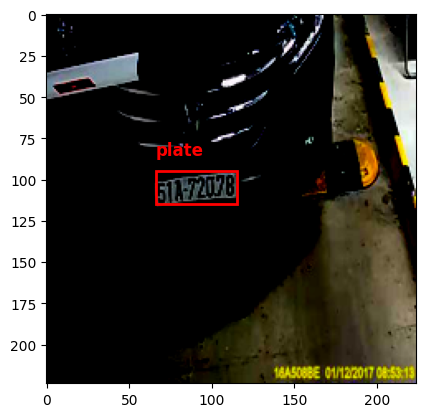

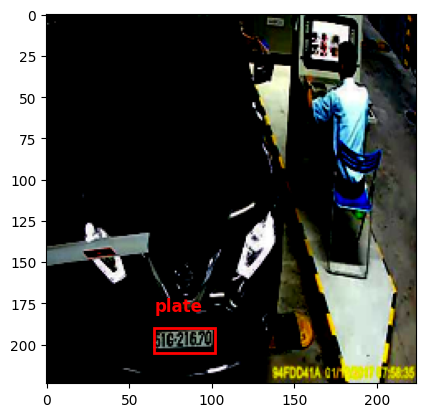

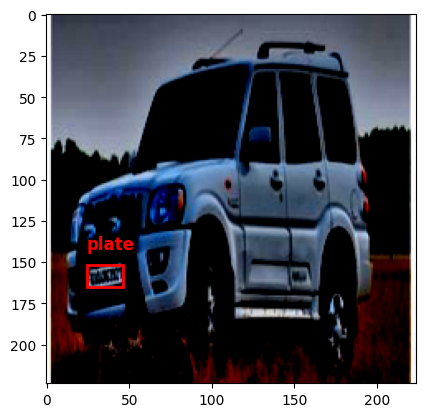

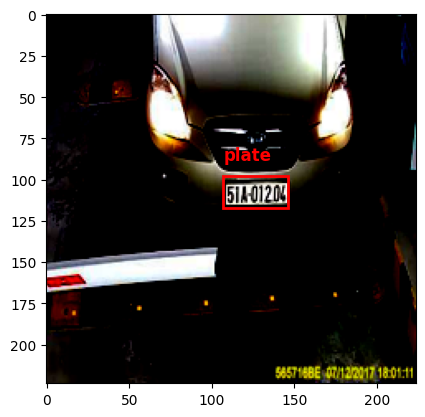

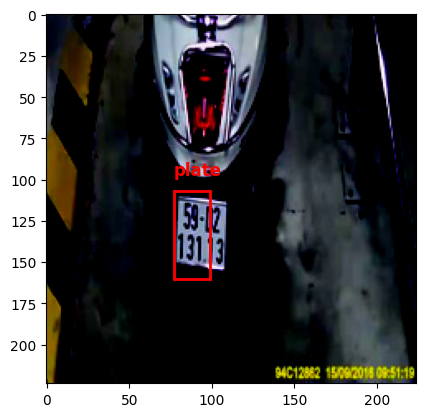

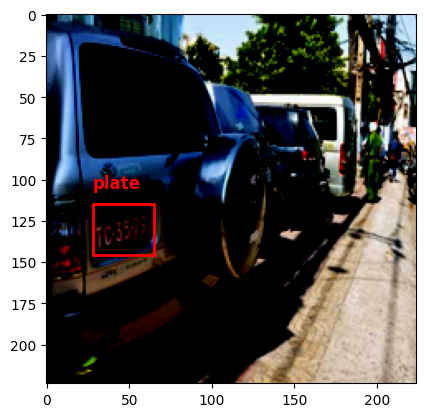

In [39]:
for index in range(batch_size):
    image = test_batch["pixel_values"][index].permute(1, 2, 0).cpu().float()
    element = decoded[index]
    detection_string = element.split("\n")[1]
    objects = extract_objects(detection_string, 224, 224, unique_labels=False)
    draw_bbox(image, objects)